In [1]:
import pickle
import gzip
import numpy as np
import scipy
import pandas as pd
import keras
import keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.layers import Input, LSTM, Dense, Lambda, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Flatten, MaxPooling2D, MaxPooling1D, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.applications import imagenet_utils
from keras import backend as K
from time import time
from keras import losses
from sklearn.metrics import  roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, mean_absolute_error
import glob
from PIL import Image
import h5py
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.gaussian_process as gp
import pandas as pd
import pickle
from joblib import dump, load
from sklearn.utils import shuffle
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings('ignore')
!pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp36-none-any.whl size=3743 sha256=4b1e0c31a25f5d42c0a6df065339e71646e113ee47268f5168f8ff4f6de27b5d
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jan 15 20:56:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 215, done.
remote: Total 215 (delta 0), reused 0 (delta 0), pack-reused 215
Receiving objects: 100% (215/215), 17.06 MiB | 12.63 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [6]:
import qmc.tf.layers as layers
import qmc.tf.models as models

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing', header = None, sep = ' ')
X = data.to_numpy()
y = X[:,-1]
X = X[:,0:-1]

In [ ]:
y.shape

(506,)

In [ ]:
X.shape

(506, 13)

Los labels van de 1 a 5

In [ ]:
print(max(y))
print(min(y))

[1.]
[0.]


In [ ]:
y = (y-1)/4
y = np.float64(y)
y = y.reshape((506,1))
X = np.float64(X)

Normalizando los datos:

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
from scipy.spatial import distance

distances = distance.cdist(X, X, 'euclidean')

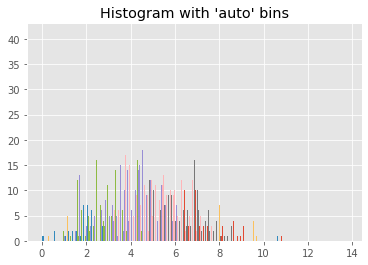

In [ ]:
import matplotlib.pyplot as plt

_ = plt.hist(distances, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

plt.show()

Sigma:

In [ ]:
print(np.mean(distances))
print(np.median(distances))

4.724219772373316
4.6649042859342265


Gamma:

In [ ]:
print(1/(np.mean(distances)**2))
print(1/(np.median(distances)**2))

0.04480637549450039
0.04595306942337859


In [ ]:
for i in range(10):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((300,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X, y = shuffle(X, y, random_state=0)

    MAE_opt = 100
    dim_y = 5
    for j in range(25):

        beta = np.random.sample()*25
        gamma = np.random.sample()*1
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 13+np.random.sample()*1024
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(13, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((206,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(13, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 1
------------ 1 beta= 2.56681464178036 gamma= 0.03730262287245367 learning_rate= 0.00025933174836123075 alpha= 0.18578610187627698 dim_x= 696 num_eig= 174
------mae =  0.2966666666666667
------------ 2 beta= 4.401296756595496 gamma= 0.9780819462669007 learning_rate= 0.0004215826487291996 alpha= 0.20826413398543475 dim_x= 233 num_eig= 58
------mae =  0.5266666666666666
------------ 3 beta= 11.599634005915677 gamma= 0.6037157919221402 learning_rate= 0.0004670714544440817 alpha= 0.10275378307872529 dim_x= 946 num_eig= 59
------mae =  0.43
------------ 4 beta= 15.75433137955089 gamma= 0.9470582967155057 learning_rate= 0.00013312336445951044 alpha= 0.050683936785267725 dim_x= 343 num_eig= 42
------mae =  0.54
------------ 5 beta= 18.298756912044745 gamma= 0.5370759806493366 learning_rate= 0.0003085307919088994 alpha= 0.6771139303433296 dim_x= 1015 num_eig= 126
------mae =  0.40333333333333343
------------ 6 beta= 9.923824118943536 gamma= 0.601529947

2nd try

In [ ]:
for i in range(10):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((300,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X, y = shuffle(X, y, random_state=0)

    MAE_opt = 100
    dim_y = 5
    for j in range(25):

        beta = np.random.sample()*25
        gamma = np.random.sample()*1
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 13+np.random.sample()*1024
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(13, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((206,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(13, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 1
------------ 1 beta= 22.056629302107044 gamma= 0.6813754727369232 learning_rate= 0.0008394870389849868 alpha= 0.3530247091489628 dim_x= 608 num_eig= 76
------mae =  0.39666666666666667
------------ 2 beta= 9.53375912395861 gamma= 0.46456073569140865 learning_rate= 0.00033377709673406965 alpha= 0.24607468469209726 dim_x= 992 num_eig= 248
------mae =  0.37333333333333335
------------ 3 beta= 12.947453501190223 gamma= 0.7059589973948347 learning_rate= 0.0008464433106756504 alpha= 0.33962717545808474 dim_x= 210 num_eig= 26
------mae =  0.44666666666666666
------------ 4 beta= 0.17466672291469032 gamma= 0.1211495881489415 learning_rate= 0.0003506369364180041 alpha= 0.2826813303357558 dim_x= 257 num_eig= 16
------mae =  0.30666666666666664
------------ 5 beta= 7.719056033174024 gamma= 0.7792142802892961 learning_rate= 0.0008164536470712711 alpha= 0.5951470841665021 dim_x= 918 num_eig= 229
------mae =  0.39
------------ 6 beta= 13.32372305554535 gamm

In [7]:
for i in range(7,10):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/boston/data/housing_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((300,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X, y = shuffle(X, y, random_state=0)

    MAE_opt = 100
    dim_y = 5
    for j in range(25):

        beta = np.random.sample()*25
        gamma = np.random.sample()*1
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 13+np.random.sample()*1024
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(13, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((206,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(13, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=13, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 8
------------ 1 beta= 4.31794060812061 gamma= 0.4030557282859424 learning_rate= 0.0006092001429411766 alpha= 0.9151456131650615 dim_x= 833 num_eig= 416
------mae =  0.43
------------ 2 beta= 3.765437387962714 gamma= 0.762439944836908 learning_rate= 0.0007224488769138519 alpha= 0.7586936151279737 dim_x= 612 num_eig= 306
------mae =  0.4666666666666667
------------ 3 beta= 14.777352257974123 gamma= 0.7466936585034885 learning_rate= 0.0007926121646869358 alpha= 0.2533240226553989 dim_x= 969 num_eig= 242
------mae =  0.45
------------ 4 beta= 18.915500675686854 gamma= 0.7930798386214389 learning_rate= 9.302270563391369e-05 alpha= 0.22502573380082402 dim_x= 608 num_eig= 38
------mae =  0.5766666666666667
------------ 5 beta= 11.88436090722242 gamma= 0.27207872987557336 learning_rate= 0.0005939674506271145 alpha= 0.2176218155812324 dim_x= 626 num_eig= 39
------mae =  0.36
------------ 6 beta= 9.475014062090281 gamma= 0.08025859384274037 learning_rate